In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

from fastai.distributed import *
from fastai.vision.all import *

from pathlib import Path
from functools import partial
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
device = torch.device('cuda:0')
core_pth = Path('/home/agrawalp2/prepositions'); assert core_pth.exists()
stupd_pth = Path('/mnt/dataset/agrawalp2/stupd_dataset'); assert stupd_pth.exists()

# Data

In [3]:
from gensim.models import KeyedVectors
import numpy as np
from autocorrect import Speller

encoder_path = core_pth/Path('real_world_data/spatialsense/baselines/GoogleNews-vectors-negative300.bin.gz')
assert encoder_path.exists()
word2vec = KeyedVectors.load_word2vec_format(encoder_path, binary=True, unicode_errors="ignore")

spell = Speller()
def phrase2vec(phrase, max_phrase_len, word_embedding_dim):
    vec = np.zeros((max_phrase_len, word_embedding_dim,), dtype=np.float32)
    for i, word in enumerate(phrase.split()[:max_phrase_len]):
        if word in word2vec: vec[i] = word2vec[word]
        elif spell(word) in word2vec: vec[i] = word2vec[spell(word)]
        else: pass
    return vec

In [4]:
# def map_spatialsenses_to_stupd(o, mapping_dict = spatialsenses_to_stupd):
#     return spatialsenses_to_stupd[o]

def is_static(x):
    static_preps = ['above', 'against_leaning', 'all_over', 'along_position', 'among', 'around_static', 
                   'behind', 'below', 'beside', 'between', 'in_front_of', 'inside', 'on', 'outside']
    
    dynamic_preps = ['against', 'along', 'around', 'by', 'down', 'from', 'into', 'into_crash', 'off', 'onto', 'out_of', 'over', 'through', 'towards', 'up', 'with']
    
    if x in static_preps: return True
    elif x in dynamic_preps: return False
    else: raise Exception("invalid relation input")

def noop(x): return x

In [5]:
class stupd(Dataset):
    def __init__(self,
                 annotations_path = stupd_pth/'annotations', 
                 x_tfms: list = None,
                 y_tfms: list = None):
        
        super().__init__()
        self.subjects = [] #x1
        self.objects = [] #x2
        self.predicates = [] #y
        
        self.classes = set()

        for annotations in annotations_path.iterdir():
            if annotations.suffix!=".csv": continue
            
            df = self._process_df(pd.read_csv(annotations))
            
            
            for i,row in df.iterrows():
                
                self.subjects.append(row['subject_category'] + ' ' + row['subject_supercategory'])
                self.objects.append(row['object_category'] + ' ' + row['object_supercategory'])
                self.predicates.append(annotations.stem)
                self.classes.add(annotations.stem)
                
                

        
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        self.x_tfms = list(x_tfms or [noop]) 
        self.y_tfms = list(y_tfms or [noop]) + [lambda y: self.class2idx[y]]
    
    def __len__(self): return len(self.predicates)
    
    def __getitem__(self, i):
        subj = self.apply_tfms(self.subjects[i], self.x_tfms)
        obj =  self.apply_tfms(self.objects[i] , self.x_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_tfms)
        
        return (torch.Tensor(subj).type(torch.cuda.FloatTensor), 
                torch.Tensor(obj).type(torch.cuda.FloatTensor), 
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o
    
    def _process_df(self, df):
        f"this function replace empty values in subject/object category and supercategory columns with an empty string ('') " 
        cols = ['subject_category', 'subject_supercategory', 'object_category', 'object_supercategory']
        
        df[cols] = df[cols].fillna('')
        return df
        

In [6]:
max_phrase_len = 3 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

ds = stupd(x_tfms = [embedding],
                 y_tfms = None)

len(ds)

149776

In [7]:
train_split = 0.8
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(len(ds)*train_split), len(ds) - int(len(ds)*train_split)])
train_ds.c, valid_ds.c = ds.c, ds.c

len(train_ds), len(valid_ds)

(119820, 29956)

In [8]:
train_dl = DataLoader(train_ds, batch_size =512 , shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 1024 , shuffle = False)

# Model

In [9]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, bn=True, relu=True):
        super().__init__()
        
        self.bn = bn
        self.relu = relu
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(output_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        if self.bn: x = self.batchnorm(x)
        if self.relu: x = self.ReLU(x)
        return x
    
    
class SimpleLanguageOnlyModel(nn.Module):
    def __init__(self, word_embedding_dim, feature_dim, c):
        super().__init__()
        self.phrase_encoder = nn.GRU(input_size = word_embedding_dim, 
                                     hidden_size = word_embedding_dim//2,
                                     num_layers = 1,
                                     batch_first = True,
                                     bidirectional = True,
                                    )

        self.linear1 = LinearBlock(word_embedding_dim, feature_dim)
        self.linear2 = LinearBlock(word_embedding_dim, feature_dim)
        self.linear3 = LinearBlock(2*feature_dim, feature_dim)
        self.linear4 = nn.Linear(feature_dim, c)
        
    def forward(self, subj, obj):
        subj = torch.squeeze(self.phrase_encoder(subj)[0][:,-1,:])
        obj = torch.squeeze(self.phrase_encoder(obj)[0][:,-1,:])
        
        subj = self.linear1(subj)
        obj  = self.linear2(obj)
        
        x = torch.cat((subj,obj), dim = 1)
        x = self.linear4(self.linear3(x))
        return x

In [10]:
dls = DataLoaders(train_dl, valid_dl)
dls.n_inp = 2
model = SimpleLanguageOnlyModel(word_embedding_dim, 512, train_ds.c).cuda()
learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

SuggestedLRs(valley=0.0006918309954926372)

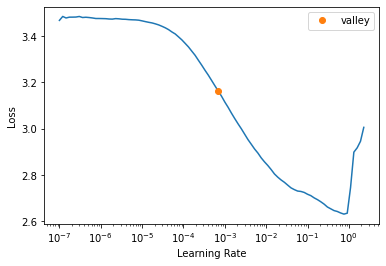

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.108673,2.091720,0.264388,0.263977,00:12
1,2.024932,2.062209,0.275337,0.274890,00:12
2,1.974805,2.001262,0.283282,0.284684,00:12
3,1.970793,1.979376,0.281546,0.282044,00:12
4,1.958884,1.960359,0.291995,0.290811,00:12
5,1.934412,1.949195,0.289258,0.289760,00:12
6,1.924766,1.942650,0.292696,0.290936,00:12
7,1.933780,1.939516,0.287388,0.287255,00:12
8,1.920368,1.935080,0.288456,0.288358,00:12
9,1.909825,1.934659,0.289992,0.289072,00:12


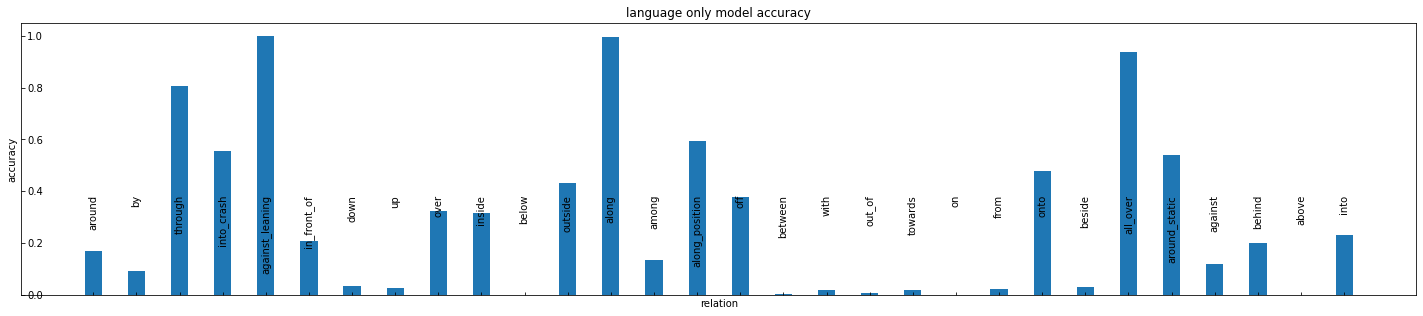

{'around': 0.17054263565891473, 'by': 0.09072978303747535, 'through': 0.8047105004906772, 'into_crash': 0.5552268244575936, 'against_leaning': 1.0, 'in_front_of': 0.2084592145015106, 'down': 0.03368421052631579, 'up': 0.02766798418972332, 'over': 0.32335329341317365, 'inside': 0.31496881496881496, 'below': 0.0009794319294809011, 'outside': 0.4334677419354839, 'along': 0.9948559670781894, 'among': 0.13431269674711438, 'along_position': 0.5929892891918208, 'off': 0.3776091081593928, 'between': 0.004008016032064128, 'with': 0.01936108422071636, 'out_of': 0.006993006993006993, 'towards': 0.01673228346456693, 'on': 0.0, 'from': 0.023638232271325797, 'onto': 0.47914547304170907, 'beside': 0.02971311475409836, 'all_over': 0.9372071227741331, 'around_static': 0.5413687436159347, 'against': 0.12044534412955465, 'behind': 0.2, 'above': 0.0, 'into': 0.2299794661190965}


In [13]:
corrects = [0]*ds.c
total = [0]*ds.c

accs = {}
for a,b,c in valid_dl:
#     res = torch.argmax(model(a,b))
    res = torch.argmax(model(a,b), dim = 1, keepdim=False)
    
    for gt,r in zip(c, res): 
        total[gt]+=1
        corrects[gt]+=(int(gt==r))

for i in range(len(corrects)):
    accs[ds.idx2class[i]]=corrects[i]/total[i]

fig = plt.figure(figsize = (25, 5))
 
# creating the bar plot
plt.bar(accs.keys(), accs.values(),
        width = 0.4)
 
plt.xlabel("relation")
plt.xticks(rotation = 90)
plt.ylabel("accuracy")
plt.title("language only model accuracy")

plt.tick_params(axis="y",direction="in", pad=-22)
plt.tick_params(axis="x",direction="in", pad=-100)
plt.show()


print(accs)

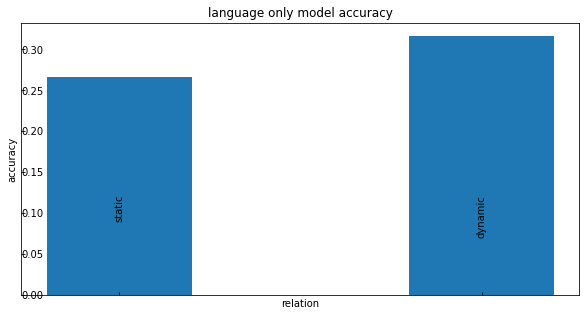

static_accuracy 0.2669451892498597
dynamic_accuracy 0.3165457288598319
0.29339881037517823


In [14]:
corrects = [0]*2
total = [0]*2

accs = [0]*2
for a,b,c in valid_dl:
#     res = torch.argmax(model(a,b))
    res = torch.argmax(model(a,b), dim = 1, keepdim=False)
    
    for gt,r in zip(c, res): 
        total[is_static(ds.idx2class[gt.item()])]+=1
        corrects[is_static(ds.idx2class[gt.item()])]+=(int(gt==r))

for i in range(len(corrects)):
    accs[i]=corrects[i]/total[i]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['static', 'dynamic'], accs,
        width = 0.4)
 
plt.xlabel("relation")
plt.xticks(rotation = 90)
plt.ylabel("accuracy")
plt.title("language only model accuracy")

plt.tick_params(axis="y",direction="in", pad=-22)
plt.tick_params(axis="x",direction="in", pad=-100)
plt.show()


print('static_accuracy', accs[0])
print('dynamic_accuracy', accs[1])

print(accs[1]*16/30 + accs[0]*14/30)